In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

# from indicator_simulation_modify_plus_train_curve import *


/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
data_file = 'jsons/cifar_all_lr_5e_2.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 5e-4
patience = 10
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 100
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)

In [3]:
minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])
# earlyStoppingStep = 9220

12140 0.18557029549438175 661
3740 0.2061524762965665


<IPython.core.display.Javascript object>


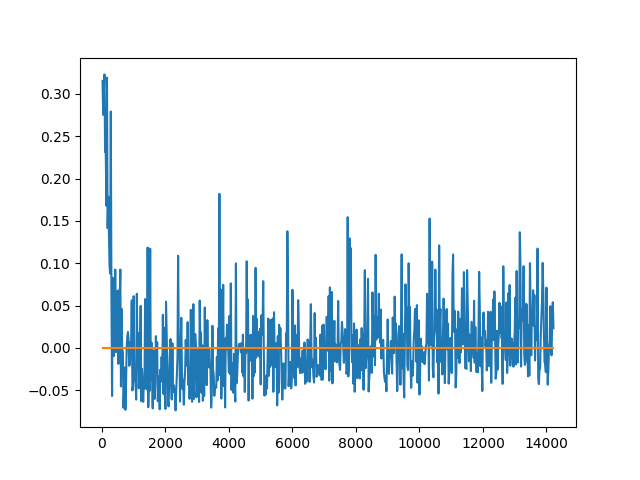

<IPython.core.display.Javascript object>


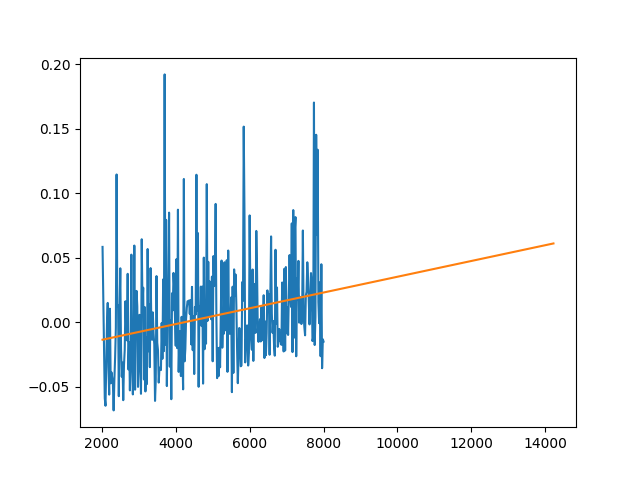

1.3372098499615797
2.23697359308583 0.026533557933622727


<IPython.core.display.Javascript object>


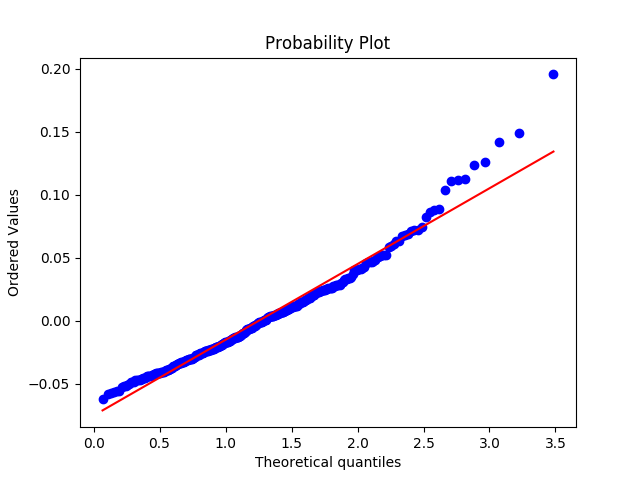

<IPython.core.display.Javascript object>


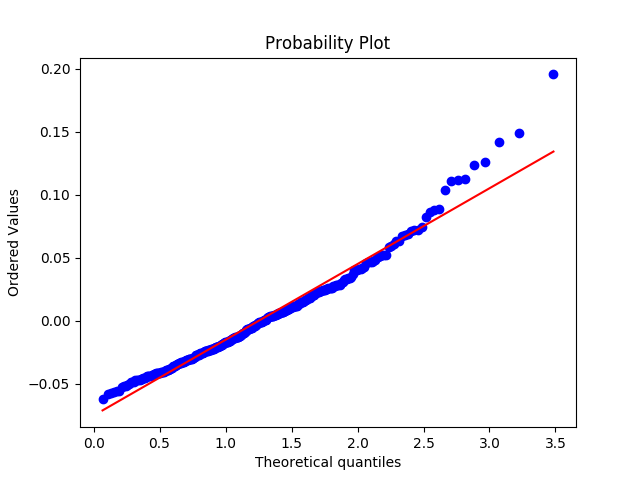

In [4]:
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
err = val_err-whole_a*np.power(steps,whole_b)
ax = plt.subplot()
ax.plot(steps, val_err-whole_a*np.power(steps,whole_b))
ax.plot(steps, np.zeros(len(steps)))

max_steps = 400
plt.figure()
whole_a, whole_b = power_regression(steps[:max_steps], val_err[:max_steps], np.ones(len(steps[:max_steps])))
err = val_err[:max_steps]-whole_a*np.power(steps[:max_steps],whole_b)
ax = plt.subplot()
ax.plot(steps[100:max_steps], err[100:])
err_a, err_b = np.linalg.lstsq(np.vstack([steps[100:max_steps], np.ones(len(steps[100:max_steps]))]).T, err[100:], rcond=None)[0]
ax.plot(steps[100:], err_a*steps[100:] + err_b)


res = err[100:] - err_a*steps[100:max_steps] - err_b
# res = val_err[smooth_win_size//2+500:smooth_win_size//2+800] - whole_smoothed_val_err[500:800]
skew = scipy.stats.skew(res)
print(skew)
k = (2/skew)**2
theta = np.sqrt(np.var(res)/k)
print(k, theta)

plt.figure()
_ = scipy.stats.probplot(res, dist=scipy.stats.rice(0), plot=plt)
plt.figure()
_ = scipy.stats.probplot(res, dist=scipy.stats.rayleigh, plot=plt)


<IPython.core.display.Javascript object>


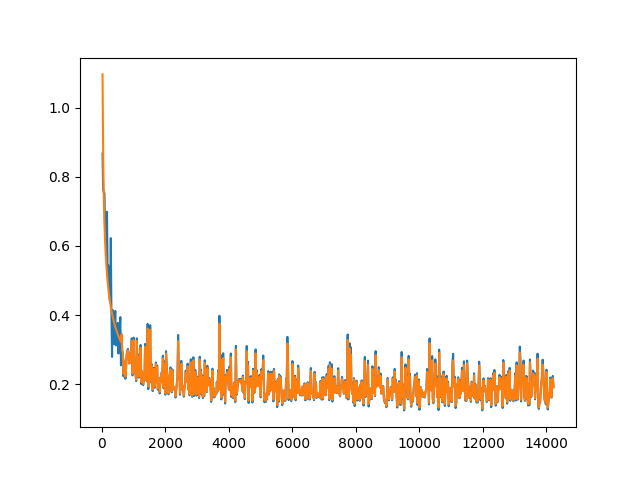

711

In [16]:
from kalman_filtering import oneIterPowerKalmanFilter

num_outliers = 0 # delete some outliers
smoothed_val_err = whole_smoothed_val_err[num_outliers:]

start_point = 30
pred_win_size = 1000
left_tail_size = 0
period = 1
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000

var_ud = 0
init_d = 0

input_data = []
for i, d in enumerate(val_err):
    if i >= pred_win_size:
        input_data.pop(0) 
    input_data.append(d)
    
    if i == start_point-1:
        KF = oneIterPowerKalmanFilter(num_epochs_between_eval,
                                 pred_win_size,
                                 period,
                                 input_data,
                                init_d,
                                  var_ud
                             )
    
    if i >= start_point and (i-start_point+1)%period == 0:
#         print(len(input_data))
        KF.oneIterKF(np.array(input_data))
#         print(KF.M_est)
#     signals = np.concatenate([signals, KF.sq_est])

# print(KF.all_estimates)

plt.figure()
KF_steps = (np.arange(len(KF.all_estimates)) + 1 + num_outliers)*num_epochs_between_eval
plt.plot(KF_steps, KF.all_original_data)
plt.plot(KF_steps, KF.all_estimates)

# a, b = power_regression(KF_steps, KF.all_estimates, np.ones(len(KF_steps)))
# plt.plot(KF_steps, power_function(KF_steps, a, b))
len(KF_steps)

<IPython.core.display.Javascript object>


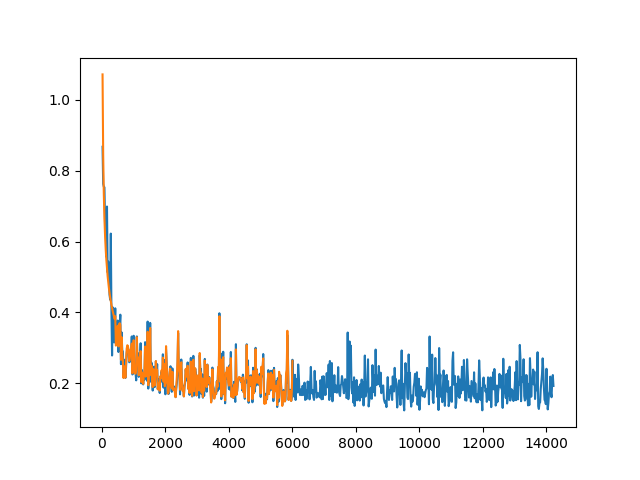

7.472378808730603e-07

In [24]:
from kalman_filtering3 import oneIterPowerKalmanFilter

num_outliers = 0 # delete some outliers
smoothed_val_err = whole_smoothed_val_err[num_outliers:]

start_point = 20
pred_win_size = 100
left_tail_size = 0
period = 1
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000

var_ud = 1e-6
init_d = 0

input_data = []
input_epochs = []
init_x = []
init_epochs = []

end = 300
for i, d in enumerate(val_err[:end]):
    if i < start_point:
        init_x.append(d)
        init_epochs.append((i+1)*num_epochs_between_eval)
    
    if i >= pred_win_size:
        input_data.pop(0) 
        input_epochs.pop(0)
    input_data.append(d)
    input_epochs.append((i+1)*num_epochs_between_eval)
    
    if i == start_point-1:
        KF = oneIterPowerKalmanFilter(num_epochs_between_eval,
#                                  pred_win_size,
#                                  period,
                                 init_x,                                      
                                init_d,
                                      init_epochs,
                                      300,
                                  var_ud
                             )
    
    if i >= start_point and (i-start_point+1)%period == 0:
        KF.oneIterKF(np.array(input_data), np.array(input_epochs), period)


# print(KF.all_estimates)

plt.figure()
KF_steps = (np.arange(len(KF.all_estimates)) + 1 + num_outliers)*num_epochs_between_eval
plt.plot(steps, val_err)
plt.plot(KF_steps, KF.all_estimates)
KF.d_est**2
# plt.plot(np.arange(len(val_err))*20+20, val_err)


# a, b = power_regression(KF_steps[:end], KF.all_estimates[:end], np.ones(len(KF_steps[:end])))
# plt.plot(steps, power_function(steps, a, b))

# a, b = power_regression(KF_steps[:end], KF.all_original_data[:end], np.ones(len(KF_steps[:end])))
# plt.plot(steps, power_function(steps, a, b))

# KF.K
# print(KF.s_pred, KF.s_est)

# plt.plot(KF_steps[len(KF_steps)-len(KF.s_pred):], KF.s_pred)
# plt.plot(KF_steps[len(KF_steps)-len(KF.s_pred):], KF.all_estimates[len(KF_steps)-len(KF.s_pred):])
# plt.plot(KF_steps[len(KF_steps)-len(KF.s_pred):], KF.s_est, 'o')

In [12]:
pred_win_size = 1000
left_tail_size = 0
period = 20
start_point = 5
KF_start_point = 30
pred_min_delta = min_delta
# pred_min_delta = 0
report_period = 20
wtype = 'linear'
num_samples = 1000
init_d = 0
var_ud = 1e-6
patience = patience

noise_est_win_size = 300


# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 2e5

# set a effective upper limit
# upper_limit_bias = 80
# upper_limit = (len(val_err) + upper_limit_bias)*num_epochs_between_eval
preds_with_patience = []
errs_with_patience = []

# var_uds = [0, 1e-6, 1e-5, 5e-5, 1e-4]
# pred_win_sizes = [20, 50, 100, 200, 300, 400, 500]
# patiences = range(13,14)
# for patience in patiences:
# preds, CIs, samples, d_ests, KF = KFIndicator(
#                                     earlyStoppingStep,
#                                     val_err,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      pred_min_delta,
#                                      patience,
#                                     report_period,
#                                     pred_win_size = pred_win_size,
#                                     period = period,
#                                     init_d = init_d,
#                                     var_ud = var_ud,
#                                     start_point = KF_start_point,
#                                     num_samples=1000,
#                                     upper_limit=upper_limit,
#                                     noise_est_win_size=noise_est_win_size)

preds, CIs, = mixKFIndicator(
                            earlyStoppingStep,
                            val_err,
                            smooth_win_size,
                             num_epochs_between_eval, 
                             pred_min_delta,
                             patience,
                            report_period,
                            pred_win_size = pred_win_size,
                            period = period,
                            init_d = init_d,
                            var_ud = var_ud,
                            start_point = start_point,
                            KF_start_point = KF_start_point,
                            num_samples=1000,
                            upper_limit=upper_limit,
                            noise_est_win_size=noise_est_win_size)

print(len(preds))
errs = CIs2errs(CIs)
preds_with_patience.append(preds)
errs_with_patience.append(errs)


100
Predicted Stopping epoch is 340.0. a = 0.8416059434276815, b = 0.01039152876802622, d^2=0
500
Predicted Stopping epoch is 776.54. a = 0.99469472725842, b = -0.030700452209611765, d^2=0
900
Predicted Stopping epoch is 2988.72. a = 1.232361730115119, b = -0.07480761830185975, d^2=0
Kalman filtering starts
Global Step: 1200
Predicted early stopping epoch: 1407.78. d^2 = 4.610394961182133e-06
Global Step: 1600
Predicted early stopping epoch: 2468.52. d^2 = 3.833961454705259e-06
Global Step: 2000
Predicted early stopping epoch: 5289.58. d^2 = 3.6221193919051256e-06
Global Step: 2400
Predicted early stopping epoch: 5449.44. d^2 = 3.235144153013865e-06
Global Step: 2800
Predicted early stopping epoch: 5105.72. d^2 = 3.800264344186112e-06
Global Step: 3200
Predicted early stopping epoch: 4489.92. d^2 = 5.105604901466056e-06
Global Step: 3600
Predicted early stopping epoch: 4358.58. d^2 = 6.567849945405749e-06
Global Step: 4000
Predicted early stopping epoch: 4632.36. d^2 = 5.65656541717661

ValueError: too many values to unpack (expected 2)

<IPython.core.display.Javascript object>


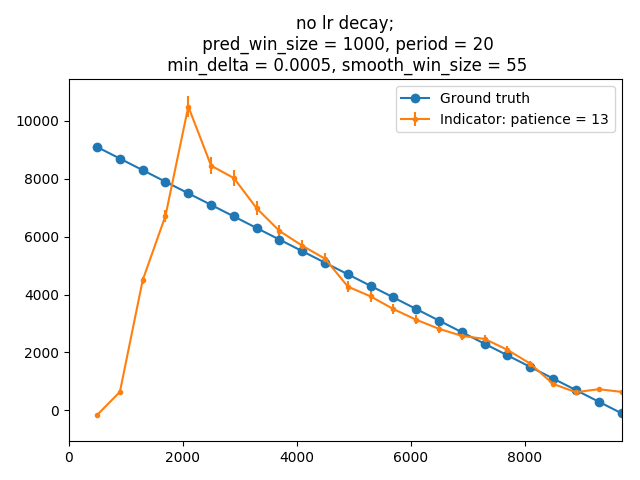

In [24]:
fig = plt.figure()

x = (start_point+period+(np.arange(len(preds)))*report_period)*num_epochs_between_eval

plt.plot(x, earlyStoppingStep-x,'-o')

legend = ['Ground truth']
# for i, v in enumerate(patiences):
for i, v in enumerate(range(13,14)):
    plt.errorbar(x, preds_with_patience[i]-x, errs_with_patience[i], fmt='.-')
    legend.append('Indicator: patience = {}'.format(v))
plt.xlim(0,earlyStoppingStep+100)
# plt.ylim(-200, 22000)
# plt.errorbar(x, preds-x, errs, fmt='.-')
# plt.legend(['Ground truth', 'KF indicator: patience = 8, min_delta = 1e-5'])
plt.legend(legend)
plt.title('no lr decay;\n pred_win_size = {0}, period = {1}\n min_delta = {2}, smooth_win_size = {4}'.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

plt.savefig('/Users/stranot/Desktop/resutls122118/cifar_subset_bs_128/Kalman_filtering/min_delta_5e_4_patience_10.png')

In [8]:
# KF.d_est, d_ests

NameError: name 'd_ests' is not defined

In [ ]:
# print(coeffs)
fig = plt.figure(figsize=[10, 16])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 2
KF_steps = (np.arange(len(KF.all_original_data)) + 1) * num_epochs_between_eval
for i in range(0,len(samples),step_size):
    co += 1
    ax = plt.subplot(8,4, co)
    ax.set_ylim(0, 1.5)
#     ax.plot(steps, val_err)
    ax.plot(KF_steps, KF.all_original_data)
    x = np.arange(1,len(samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x,samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + (i+1)*report_period + period)*num_epochs_between_eval
    s = max(0, ((start_point+(i+1)*report_period + period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,20000)
    
fig.tight_layout()   

In [ ]:
num = int(upper_limit//num_epochs_between_eval)
s_queue = list(KF.s_est)
epoch_queue = list(KF.epochs)
predicts = []
a, b = power_regression(np.array(epoch_queue), np.array(s_queue), np.ones(len(s_queue)))
for i in range(1,num):
            
#             if (i-1) % KF.pointPeriod == 0:
#                 a, b = power_regression(np.array(epoch_queue), np.array(s_queue), np.ones(len(s_queue)))
#                 print(a,b)
            if i == 1:
                store_a = a
                store_b = b
            epoch = KF.epochs[-1] + i * KF.numEpsBtwVal
            if len(epoch_queue) >= KF.predWinSize:
                epoch_queue.pop(0)
            epoch_queue.append(epoch)
#             print(epoch_queue)

            predict = power_function(epoch, a, b) + np.tanh(np.power(KF.d_est,2)*(epoch-KF.epochs[-1]))
            predicts.append(predict)
            if len(s_queue) >= KF.predWinSize:
                s_queue.pop(0)
            s_queue.append(predict)

# print(predicts)

fig = plt.figure()
all_points = np.concatenate([KF.all_estimates,predicts])
steps0 = (np.arange(len(all_points))+1)*num_epochs_between_eval
steps1 = (np.arange(len(all_points)+50)+1)*num_epochs_between_eval
plt.plot(steps0, all_points)
plt.plot(steps0[:len(samples[-1])], samples[-1])
# plt.plot(steps1, power_function(steps1, KF.c_est, KF.d_est) + power_function(steps1, store_a, store_b))
plt.xlim(0, 40000)
# plt.ylim(0,1)

a,b, KF.d_est, predict, np.tanh(np.power(d_ests[-1],2)*(epoch-KF.epochs[-1])), power_function(epoch, a, b)